# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>
- TAs: Tong Zeng <tozeng@syr.edu>, Priya Matnani <psmatnan@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your http://notebook.acuna.io workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [1]:
# load these packages
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, classification, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import pandas as pd

# Part 2: Multilayer perceptrons:

**Note 1**: Due to the memory requirements of MLPs and the limitations of the server `notebook.acuna.io`, you cannot run should not run multiple jupyter notebooks at the same time or your account might run out of memory. You can check which notebooks are opened by going to http://notebook.acuna.io/#running. Shutdown the ones that you no longer need.

**Note 2**: Due to the time it takes to fit some of this model, if you want to validate your entire notebook, instead of clicking `Validate` which may fail, I would advise you to go to `Kernel` -> `Restart and Run All`. If all tests pass, it is equivalent to `Validate`.

## **Question 1 (10 pts):** 
Choose the best model based on accuracy between multilayer perceptrons predicting whether a face is from an `old` person or not based on `pixels`. Compare the following architectures:

 1. No hidden layers
 1. One hidden layer with 10 neurons
 1. Two Hidden layers with 30 neurons each

Fit both models to `training` and estimate the AUC on validation. You don't need to build a Pipeline because the features needed are in the column `pixels`. Pick the best one based on validation performance. The input dimension is 2304 (=48\*48) and the output is 2. Store the first, second, and third models in the variables `mlp_model1`, `mlp_model2`, and `mlp_model3`. Additionally, fit a logistic regression model and call it `lr_model`. Store the AUC on `AUC1`, `AUC2`, `AUC3`, and `AUC_lr`. Based on these performances, store the best model in `best_model`. Use the default paramerts for all the neural networks.

**Detecting an old or young face based on an image**

We will use the [UTKFace](https://susanqq.github.io/UTKFace/) dataset to predict whether a face is old or young based on an image. The dataset is already preprocessed and put in a parquet file. The schema of the parquet is as follows:

- `face_id`: identifier of the face
- `age`: age of the face
- `gender`: 1 = female and 0 = male
- `pixels`: flatten version of a 48 by 48 pixel image

In [2]:
# read data
# pixels: 48x48 pixel gray values (between 0 and 255) 
utkface_df = spark.read.parquet('/datasets/utkface_dataset.parquet').\
    withColumn('old', (fn.col('age')>30).cast('int'))

# use these splits throughout the homework
training, validation, testing = utkface_df.randomSplit([0.6, 0.3, 0.1], seed=0)

# to compute AUC use the following evaluator
evaluator = evaluation.BinaryClassificationEvaluator(labelCol='old')

In [3]:
# utility function to display the first element of a Spark dataframe as an image
def display_first_as_img(df):
    plt.figure()
    plt.imshow(df.first().pixels.reshape([48,48]), 'gray');

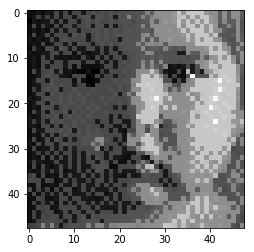

In [4]:
# show random faces
display_first_as_img(utkface_df.where('old=0').orderBy(fn.rand()))

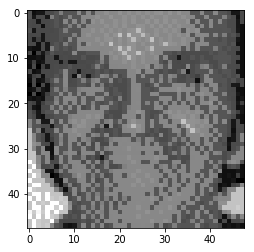

In [5]:
# show random faces
display_first_as_img(utkface_df.where('old=1').orderBy(fn.rand()))

In [6]:
old_to_number_model = feature.StringIndexer(inputCol='old', outputCol='label').\
    fit(training)
old_to_number_model.transform(training).show()

+-------+----+------+--------------------+---+-----+
|face_id| age|gender|              pixels|old|label|
+-------+----+------+--------------------+---+-----+
| 2238.0| 3.0|   1.0|[11.0,46.0,17.0,4...|  0|  0.0|
| 2239.0| 3.0|   1.0|[139.0,139.0,140....|  0|  0.0|
| 2243.0|51.0|   1.0|[11.0,17.0,11.0,5...|  1|  1.0|
| 2245.0| 3.0|   1.0|[139.0,175.0,175....|  0|  0.0|
| 2246.0| 3.0|   0.0|[54.0,60.0,54.0,6...|  0|  0.0|
| 2247.0| 1.0|   0.0|[95.0,53.0,95.0,9...|  0|  0.0|
| 2248.0|54.0|   0.0|[54.0,61.0,90.0,9...|  1|  1.0|
| 2249.0|49.0|   0.0|[53.0,96.0,97.0,1...|  1|  1.0|
| 2250.0|35.0|   0.0|[61.0,61.0,61.0,9...|  1|  1.0|
| 2251.0|20.0|   0.0|[53.0,53.0,90.0,6...|  0|  0.0|
| 2252.0|18.0|   1.0|[46.0,82.0,46.0,4...|  0|  0.0|
| 2253.0| 5.0|   0.0|[139.0,53.0,53.0,...|  0|  0.0|
| 2254.0|21.0|   1.0|[0.0,46.0,0.0,0.0...|  0|  0.0|
| 2256.0|19.0|   1.0|[0.0,53.0,0.0,0.0...|  0|  0.0|
| 2257.0|58.0|   0.0|[103.0,97.0,103.0...|  1|  1.0|
| 2258.0|52.0|   0.0|[96.0,96.0,96.0,6...|  1|

In [7]:
from pyspark.ml import classification

In [8]:
mlp_model1 = classification.MultilayerPerceptronClassifier(seed=0, featuresCol='pixels',labelCol='old', layers=[48*48,2]).fit(training)

mlp_model2 = classification.MultilayerPerceptronClassifier(seed=0, featuresCol='pixels',labelCol='old', layers=[48*48,10,2]).fit(training)

mlp_model3 = classification.MultilayerPerceptronClassifier(seed=0, featuresCol='pixels',labelCol='old', layers=[48*48,30,30,2]).fit(training)


In [12]:
AUC1 = evaluator.evaluate(mlp_model1.transform(validation))
AUC2 = evaluator.evaluate(mlp_model2.transform(validation))
AUC3 = evaluator.evaluate(mlp_model3.transform(validation))

In [13]:
AUC1 = evaluator.evaluate(mlp_model1.transform(validation))
AUC2 = evaluator.evaluate(mlp_model2.transform(validation))
AUC3 = evaluator.evaluate(mlp_model3.transform(validation))
print(AUC1," ",AUC2," ",AUC3," ")

0.6553021795088415   0.7411619574831793   0.8198153430266676  


In [15]:
lr_model = classification.LogisticRegression(featuresCol='pixels',labelCol='old').fit(training)
AUC_lr = evaluator.evaluate(lr_model.transform(validation))
print(AUC_lr)

0.8772642343891364


In [16]:
# in this cell,
# create mlp_model1, mlp_model2, mlp_model3, lr_model, AUC1, AUC2, AUC3, AUC_lr, and best_model
# YOUR CODE HERE

best_model = lr_model

In [17]:
# 10 points
assert type(mlp_model1) == classification.MultilayerPerceptronClassificationModel
assert type(mlp_model2) == classification.MultilayerPerceptronClassificationModel
assert type(mlp_model3) == classification.MultilayerPerceptronClassificationModel
assert (type(best_model) == classification.MultilayerPerceptronClassificationModel or 
        type(best_model) == classification.LogisticRegressionModel)


## **Question 2 (10 pts):** 
See the notebook in the IST 718 repository for the deep learning section. Build a model for the caltech101 dataframe created below where you are trying to predict whether an object is a face or not. Use a multi-layer perceptron with one hidden layer with 30 neurons. The input image is 60 by 40. Assign the estimated model to the variable `face_model` and use the evaluator defined below to estimate its AUC and store it in `AUC_face`

In [18]:
# the following dataframe will have the the caltech dataset with the pixels in column pixels and the
# label is_face = 1 if the pixels are of a face and 
caltech101_df = spark.read.parquet('/datasets/caltech101_60_40_ubyte.parquet').\
    select(fn.col('raw_pixels').alias('pixels'), 
           ((fn.col('category') == "Faces_easy") | (fn.col('category') == "Faces")).cast('int').alias('is_face'))

caltech101_df = caltech101_df.where('is_face = 0').limit(400).\
    union(caltech101_df.where('is_face = 1').limit(400)).\
    cache()

caltech_training, caltech_evaluation = caltech101_df.randomSplit([0.8, 0.2], seed=0)

# use this evaluator to compute the AUC on validation
evaluator_face = evaluation.BinaryClassificationEvaluator(labelCol='is_face')

In [19]:
# example what caltech_training and caltech_evaluation have
caltech_evaluation.printSchema()

root
 |-- pixels: vector (nullable = true)
 |-- is_face: integer (nullable = true)



In [20]:
mlpNew = classification.MultilayerPerceptronClassifier(seed=0).\
    setStepSize(0.2).\
    setFeaturesCol('pixels').setLabelCol('is_face')

In [21]:
mlpFace = mlpNew.setLayers([60*40, 30, 2])

In [22]:
# Here, create face_model and AUC_face variables here
face_model = mlpFace.fit(caltech_training)
AUC_face = evaluator_face.evaluate(face_model.transform(caltech_evaluation))

In [23]:
AUC_face

0.9559966216216217

In [24]:
# 10 points
assert type(face_model) == classification.MultilayerPerceptronClassificationModel
assert len(face_model.layers) == 3
assert AUC_face > 0.5

## **Question 3 (10 pts):** 

Using the boilerplate code provided below, find four images of objects online (the image URLs) one for each of case corresponding to a true positive, true negative, false positive, and false negative. Use the model from Question 2 (`face_model`). Remember that you are predicting `is_face = 1` so a "positive" case is being face and a negative is being not a face. A true positive is "the model predicts face and image is a face", false negative is "the model predict not a face but image is a face". The images that you find must be fair in that they must be similar to the ones in the training dataset. The professor provides one true positive URL and one true negative URL as examples but you still must provide another set of true positive and true negative. Store the the URL of your cases in `TP_URL`, `TN_URL`, `FP_URL`, and `FN_URL`.

In [25]:
from PIL import Image
import requests
from io import BytesIO
from pyspark.ml.linalg import Vectors
import numpy as np

def get_image(url):
    # face
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    shrinked_img = np.array(img.resize([60, 40]).convert('P'))
    return shrinked_img
                          
def display_image(url):
    plt.figure()
    plt.imshow(get_image(url), 'gray')
    plt.show()

def predict_image(model, url):
    new_image = get_image(url).flatten()
    new_img_df = spark.createDataFrame([[Vectors.dense(new_image)]], ['pixels'])
    return model.transform(new_img_df)

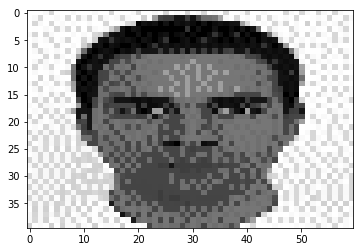

In [26]:
# POSITIVE (face)
face_url = "https://www.uni-regensburg.de/Fakultaeten/phil_Fak_II/Psychologie/Psy_II/beautycheck/english/durchschnittsgesichter/m(01-32)_gr.jpg"
display_image(face_url)

In [27]:
# TRUE POSITIVE: face predicted
predict_image(face_model, face_url).show()

+--------------------+--------------------+--------------------+----------+
|              pixels|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[225.0,225.0,225....|[-2.7241717679970...|[0.01365070421933...|       1.0|
+--------------------+--------------------+--------------------+----------+



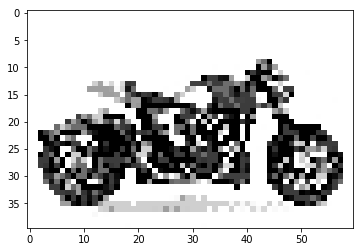

In [28]:
# Example: NEGATIVE (motorcycle)
motorcycle_url = 'http://imagesvc.timeincapp.com/v3/foundry/image/?q=70&w=1440&url=https%3A%2F%2Ftimedotcom.files.wordpress.com%2F2017%2F11%2Farch-1s-full-right-side.jpg%3Fquality%3D85'
display_image(motorcycle_url)

In [29]:
# TRUE NEGATIVE 
predict_image(face_model, motorcycle_url).show()

+--------------------+--------------------+--------------------+----------+
|              pixels|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[225.0,225.0,225....|[1.99291090713920...|[0.99685233907303...|       0.0|
+--------------------+--------------------+--------------------+----------+



In [30]:
# Your answer here
# Find (e.g., Google Images) URLs for 1 true positive, 1 true negative, 1 false positive, and 1 false negative.
# Here, create variables TP_URL, TN_URL, FP_URL, and FN_URL for a true positive,
# true negative, false positive, and false negative, respectively. DO NOT USE EXAMPLES PROVIDED BY PROFESSOR
# YOUR CODE HERE

TN_URL ='https://images.pexels.com/photos/210019/pexels-photo-210019.jpeg?auto=compress&cs=tinysrgb&dpr=1&w=500'
TP_URL = 'https://tribzap2it.files.wordpress.com/2016/04/chord-overstreet-austin-butler-gi1.jpg?w=900'
FP_URL = 'https://i.pinimg.com/originals/e7/b0/fe/e7b0fe236483c9485dd7d96cdb2a5a6a.jpg'
FN_URL = 'https://res.cloudinary.com/campus-job/image/upload/t_student-public-page/v1/profile_pictures/w5p8ylL1DG_20180925.jpg'


True positive


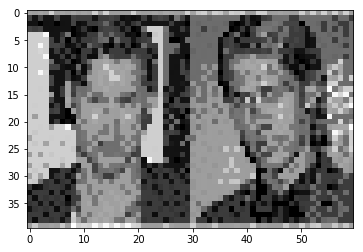

+--------------------+--------------------+--------------------+----------+
|              pixels|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[145.0,140.0,145....|[-2.7241717679970...|[0.01365070421933...|       1.0|
+--------------------+--------------------+--------------------+----------+

True negative


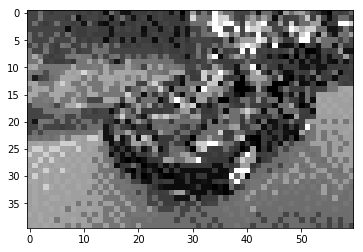

+--------------------+--------------------+--------------------+----------+
|              pixels|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[60.0,61.0,97.0,6...|[1.07328034542408...|[0.94867623994276...|       0.0|
+--------------------+--------------------+--------------------+----------+

False positive


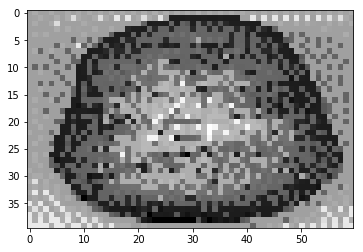

+--------------------+--------------------+--------------------+----------+
|              pixels|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[96.0,102.0,96.0,...|[-2.7241717679970...|[0.01365070421933...|       1.0|
+--------------------+--------------------+--------------------+----------+

False negative


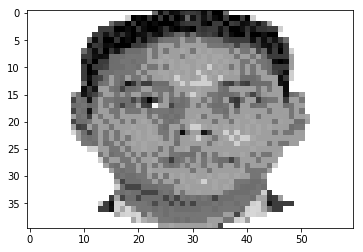

+--------------------+--------------------+--------------------+----------+
|              pixels|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[225.0,225.0,225....|[1.07328034542408...|[0.94867623994276...|       0.0|
+--------------------+--------------------+--------------------+----------+



In [31]:
# this code will display your solution
print("True positive")
display_image(TP_URL)
predict_image(face_model, TP_URL).show()
print("True negative")
display_image(TN_URL)
predict_image(face_model, TN_URL).show()
print("False positive")
display_image(FP_URL)
predict_image(face_model, FP_URL).show()
print("False negative")
display_image(FN_URL)
predict_image(face_model, FN_URL).show()

In [32]:
# 10 pts
assert 0 <= predict_image(face_model, TP_URL).first().prediction <= 1
assert 0 <= predict_image(face_model, TN_URL).first().prediction <= 1 
assert 0 <= predict_image(face_model, FP_URL).first().prediction <= 1
assert 0 <= predict_image(face_model, FN_URL).first().prediction <= 1

## **Question 4 (10 pts)**: 

Study neural network architectures to fit the infamous two-spirals dataset. There is boilerplate code to do the data generation, plotting and evaluation. Play with number of hidden layers and with the number of neurons per hidden layer but **limit the number of total weights to no more than 200 to achieve an accuracy greater than 70%**. *You can also increase the parameter `maxIter` to improve the performance*. The input dimension is 2 and the output dimension is 2. Use the convenience function `fit_and_plot` to fit an estimator. Assign the fitted model to a variable `ts_model`. Look at the example with logistic regression. 

In [33]:
# BOILERPLATE CODE
from sklearn import manifold, datasets
from pyspark.sql import Row
import numpy as np
import matplotlib.pyplot as plt

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(1000)

# X, y = datasets.make_circles(n_samples=300, factor=.6, noise=.1, random_state=0)
data = spark.createDataFrame(  [Row(x=float(x[0]), y=float(x[1]), label=int(label)) for x, label in zip(X, y)])

plotting_data = spark.range(100).selectExpr("(id - 50)/3 as x").\
  crossJoin(spark.range(100).selectExpr("(id - 50)/3 as y"))

  
def fit_and_plot(estimator):
    """Plot the data and decision surface of estimator"""    
    
    plt.figure()
    va= feature.VectorAssembler(inputCols=['x', 'y'], outputCol='features')
    
    model = estimator.fit(va.transform(data))
    
    df = va.transform(plotting_data)    
    pp = model.transform(df).select('x', 'y', 'prediction').toPandas()

    fig, ax = plt.subplots(figsize=(5,5))
    plt.contourf(pp.x.unique(), pp.y.unique(), 
                 pp.prediction.values.reshape(pp.x.unique().shape[0], 
                                              pp.x.unique().shape[0]).T, alpha=0.5)
    colors=['blue', 'red']
    for i, grp in data.toPandas().groupby('label'):
        grp.plot(x='x', y='y', kind='scatter', ax=ax,color=colors[i])  

    acc = model.transform(va.transform(data)).\
        selectExpr('avg(CAST((label = prediction) AS FLOAT)) AS avg').first().avg
    plt.title('Accuracy = {}'.format(acc))
    plt.show()
    return model

def ts_accuracy(model):
    va= feature.VectorAssembler(inputCols=['x', 'y'], outputCol='features')
    acc = model.transform(va.transform(data)).\
        selectExpr('avg(CAST((label = prediction) AS FLOAT)) AS avg').first().avg
    return acc

<Figure size 432x288 with 0 Axes>

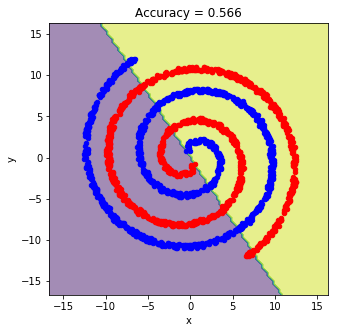

Model accuracy:  0.566


In [34]:
# example estimator that is not very good
# the plot shows the performance
ts_model = fit_and_plot(classification.LogisticRegression())
# but also you can examine it with ts_accuracy
print("Model accuracy: ", ts_accuracy(ts_model))

<Figure size 432x288 with 0 Axes>

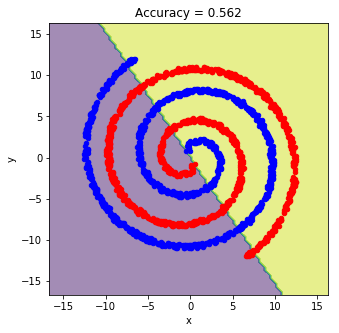

Model accuracy:  0.562


In [35]:
# example multilayer perceptron with no hidden layers
# the plot shows the performance
ts_model = fit_and_plot(classification.MultilayerPerceptronClassifier(layers=[2, 2]))
# but also you can examine it with ts_accuracy
print("Model accuracy: ", ts_accuracy(ts_model))

<Figure size 432x288 with 0 Axes>

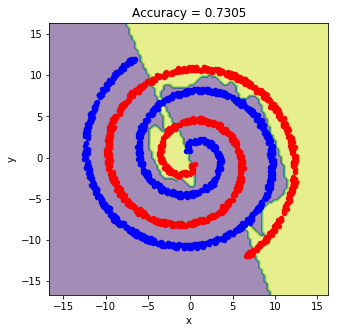

Model accuracy:  0.7305
186


In [36]:
# your answer here
# provide your answer below. The model estimator should be a MultilayerPerceptronClassifier. 
# Play with the layers and maxIter but not exceed the weights beyond 200 to achieve more than 80% accuracy
# YOUR CODE HERE
ts_model = fit_and_plot(classification.MultilayerPerceptronClassifier(maxIter=2000, layers=[2,8,14,2,2]))
# but also you can examine it with ts_accuracy
print("Model accuracy: ", ts_accuracy(ts_model))
print(len(ts_model.weights))

In [37]:
# 10 pts
assert type(ts_model) == classification.MultilayerPerceptronClassificationModel
assert len(ts_model.weights) <= 200
np.testing.assert_array_less(0.7, ts_accuracy(ts_model))

**Question 5 (5 pts):**

### beat the professor!
Starting from the following Tensorflow Playground [here](http://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.00001&regularizationRate=0&noise=0&networkShape=4,2&seed=0.00846&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false),

change any of the following parameters and create a variable that contain the parameter you chose:

- Learning rate (`learning_rate`)
- Activation (`activation`)
- Regularization (`reg`)
- Regularization rate (`reg_rate`)
- Number of neurons per hidden layer (`hidden_layers`: this should be a list with the number of neurons for each hidden layer)

Usually, after you change any of the allowable parameters, you will need to restart the learning by pressing the *reset network* button and then pressing the *play* button.

But DO NOT CHANGE any of the following:

- Data
- Ratio of training to test data
- Noise
- Batch size
- Features

Report the parameters you use to achieve less than **0.01 test loss before 20,000 epochs**

In [42]:
# put your variables chosen below:
learning_rate = 0.01
activation = 'RELU'
reg = 'L2'
reg_rate = 0.001
hidden_layers = [8, 8, 8, 8, 7, 7]

In [43]:
# 5 pts
assert type(learning_rate) == float
assert activation.upper() in ['RELU', 'SIGMOID', 'TANH', 'LINEAR']
assert reg.upper() in ['NONE', 'L1', 'L2']
assert reg_rate >= 0
assert type(hidden_layers) == list and len(hidden_layers) > 0